In [1]:
# Correr para instalar, en caso de ser necesario
!pip install torch torchvision
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.nn import Linear, Dropout
from torch_geometric.datasets import Amazon

In [3]:
# Import dataset from PyTorch Geometric
dataset = Amazon(root=".", name="Computers")

Processing...
Done!


In [4]:
# Access the first data instance
data = dataset[0]

In [21]:
class multiGAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, num_layers=3, heads=32):
        super().__init__()
        self.num_layers = num_layers

        # Primera capa GAT
        self.gat_layers = torch.nn.ModuleList()
        self.gat_layers.append(GATv2Conv(dim_in, dim_h, heads=heads))

        # Capas intermedias GAT
        for _ in range(num_layers - 2):
            self.gat_layers.append(GATv2Conv(dim_h * heads, dim_h, heads=heads//2))

        # Última capa GAT
        self.gat_layers.append(GATv2Conv(dim_h * heads//2, dim_out, heads=1))

        # Dropout
        self.dropout = Dropout(p=0.3) #p=0.6

In [22]:
def forward(self, x, edge_index):
    h = x
    for i, gat_layer in enumerate(self.gat_layers):
        h = self.dropout(h)
        h = gat_layer(h, edge_index)
        if i < self.num_layers - 1:
            h = F.elu(h)
    return F.log_softmax(h, dim=1)

multiGAT.forward = forward

In [23]:
def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01) #weight_decay=0.01

    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if(epoch % 20 == 0):
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

multiGAT.fit = fit

In [24]:
@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

multiGAT.test = test

In [25]:
# Fijar la semilla
torch.manual_seed(42)

# Get the total number of nodes
num_nodes = data.num_nodes

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split indices
train_end = int(train_ratio * num_nodes)
val_end = train_end + int(val_ratio * num_nodes)

# Create masks
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[perm[:train_end]] = True
data.val_mask[perm[train_end:val_end]] = True
data.test_mask[perm[val_end:]] = True

In [26]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [27]:
multigat = multiGAT(dataset.num_features, 32, dataset.num_classes)
print(multigat)

multigat.fit(data, epochs=160) #100

multiGAT(
  (gat_layers): ModuleList(
    (0): GATv2Conv(767, 32, heads=32)
    (1): GATv2Conv(1024, 32, heads=16)
    (2): GATv2Conv(512, 10, heads=1)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch   0 | Train Loss: 2.556 | Train Acc:  4.11% | Val Loss: 2.53 | Val Acc: 4.58%
Epoch  20 | Train Loss: 2.700 | Train Acc: 35.08% | Val Loss: 2.64 | Val Acc: 35.78%
Epoch  40 | Train Loss: 1.181 | Train Acc: 67.06% | Val Loss: 1.31 | Val Acc: 65.75%
Epoch  60 | Train Loss: 0.867 | Train Acc: 73.93% | Val Loss: 0.85 | Val Acc: 73.89%
Epoch  80 | Train Loss: 0.586 | Train Acc: 82.20% | Val Loss: 0.60 | Val Acc: 82.98%
Epoch 100 | Train Loss: 0.477 | Train Acc: 85.11% | Val Loss: 0.52 | Val Acc: 85.16%
Epoch 120 | Train Loss: 0.434 | Train Acc: 87.08% | Val Loss: 0.48 | Val Acc: 86.91%
Epoch 140 | Train Loss: 0.381 | Train Acc: 88.56% | Val Loss: 0.47 | Val Acc: 86.55%
Epoch 160 | Train Loss: 0.355 | Train Acc: 88.99% | Val Loss: 0.41 | Val Acc: 87.64%


In [28]:
# Test
acc = multigat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 89.17%


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Asumiendo que tu modelo y datos ya están en el dispositivo correcto
multigat.eval()  # Establecer el modelo en modo evaluación

with torch.no_grad():
    logits = multigat(data.x, data.edge_index)  # Logits son las salidas del modelo antes de la activación softmax
    predictions = logits.argmax(dim=1)  # Obtener la clase predicha

# Etiquetas reales
true_labels = data.y

# Verificar que estén en la CPU para trabajar con numpy
if predictions.is_cuda:
    predictions = predictions.cpu()
if true_labels.is_cuda:
    true_labels = true_labels.cpu()

predictions = predictions.numpy()
true_labels = true_labels.numpy()

# Calcular la matriz de confusión
conf_mat = confusion_matrix(true_labels, predictions, labels=np.arange(dataset.num_classes))

# Normalizar la matriz de confusión por filas
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

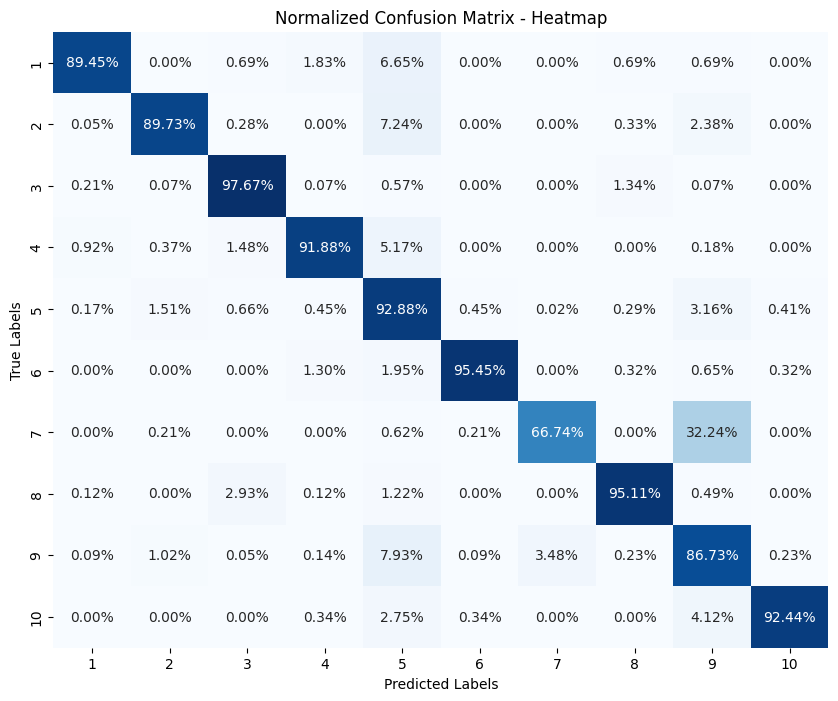

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap='Blues', cbar=False, xticklabels=range(1, dataset.num_classes+1), yticklabels=range(1, dataset.num_classes+1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix - Heatmap')
plt.show()